In [1]:
import cobra
import os 
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
ecpy_path = '../../../ecpy/'
sys.path.append(os.path.abspath(ecpy_path))
import utils
import ecpy

In [3]:
import importlib
importlib.reload(utils)
importlib.reload(ecpy)

<module 'ecpy' from '/Users/gangl/Documents/GitHub/Halo-GEM/ecpy/ecpy.py'>

#### 1. Load the GEM model

In [37]:
model_file = '../../../ModelFiles/json/Halo_GEM_v1.json'
model = cobra.io.load_json_model(model_file)

In [39]:
def get_r_max(model):
    model.objective = 'Biomass_v1'
    model.objective_direction = 'max'
    model.reactions.NGAM.lower_bound = 0
    return model.optimize()

In [40]:
s = get_r_max(model)

In [46]:
s.status

'optimal'

In [44]:
model.reactions.Exchange_Glucopyranose

Reaction identifier,Exchange_Glucopyranose
Name,
Memory address,0x07ff2ac959a20
Stoichiometry,--> Glucopyranose_e --> D-Glucose
GPR,
Lower bound,0
Upper bound,1


In [43]:
s.fluxes['Exchange_Glucopyranose']

1.0

In [5]:
utils.report_model(model)

Reactions: 2270
Metabolites: 2339


In [6]:
utils.set_bound(model,'Exchange_Glucopyranose',lb=0,ub=10)

In [7]:
utils.test_biomass_production(model)

(<Solution 0.604 at 0x7ff2c0f84b00>, <Solution 13.419 at 0x7ff2c0f88438>)

In [8]:
biomass= model.reactions.Biomass_v1
atp_c = model.metabolites.ATP_c

In [9]:
biomass.metabolites[atp_c]

-75.37723

In [10]:
glc_up = model.reactions.Exchange_Glucopyranose

In [11]:
glc_up.upper_bound

10

#### 2. Convert to irreversible model

In [12]:
irrModel = ecpy.convertToIrrev(model)

In [13]:
utils.report_model(irrModel)

Reactions: 2691
Metabolites: 2339


In [14]:
utils.test_biomass_production(irrModel)

(<Solution 0.604 at 0x7ff2c2f8d5f8>, <Solution 13.419 at 0x7ff2c2f8d780>)

#### 3. Add enzymes into model: eModel, need kcat values

##### 3.1 prepare a dictionary with (enz_id,rxn_id) as keys and kcasts as values
In this reconstruction, kcats for reactions were matched only at the reaction level, meaning that all iso-enzymes that catalyze the same reaction have the same kcat.

In [15]:
df_enz_kcat = pd.read_csv('../Results/mapped_kcats.csv',index_col=0)
# In this file, all kcats are in the unit of 1/s and log10 transformed

In [16]:
df_enz_kcat.head(5)

,log10_kcat_mean,log10_kcat_std,log10_kcat_max,log10_kcat_max_std
RXN-6021,1.749244,0.915640,3.452080,0.294740
DEOXYRIBOSE-P-ALD-RXN,1.883541,0.734648,2.542757,0.390754
THREONINE-ALDOLASE-RXN,0.271842,1.000000,0.271842,1.000000
R00945,1.435783,0.816750,2.287620,0.741109
R00945_REV,0.698970,1.000000,0.698970,1.000000


In [17]:
kcat_dict = ecpy.prepare_kcats_dict(irrModel,df_enz_kcat,'log10_kcat_max')
# In this dictionary, all kcats are in the unit of 1/h 

In [18]:

#for k,v in kcat_dict.items(): kcat_dict[k] = 1e8

(array([  8.,  26., 116., 177., 418., 697., 482., 180.,  99., 292.]),
 array([-0.32051158,  0.75451998,  1.82955154,  2.9045831 ,  3.97961466,
         5.05464622,  6.12967778,  7.20470933,  8.27974089,  9.35477245,
        10.42980401]),
 <a list of 10 Patch objects>)

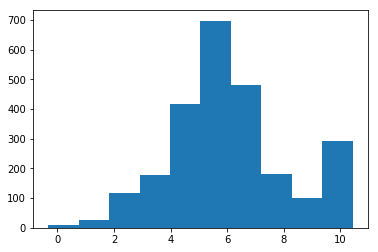

In [19]:
plt.hist(np.log10(list(kcat_dict.values())))

##### 3.2 add enzymes into reactions

In [20]:
eModel = ecpy.convertToEnzymeModel(irrModel,kcat_dict)

Number of enzymes: 1169


In [21]:
utils.report_model(eModel)

Reactions: 4681
Metabolites: 3833


In [22]:
utils.test_biomass_production(eModel)

(<Solution 0.604 at 0x7ff2c3e38c18>, <Solution 13.419 at 0x7ff2c3e38860>)

#### 4. add proteomics

In [23]:
dfomics = pd.read_csv('../proteomics/protein_abandance.csv',index_col=0)
dftot = pd.read_csv('../proteomics/total_protein_abandance.csv',index_col=0)

In [24]:
def prepare_omics_for_one_condition(dfomics,dftot,dfmws,condition_id,model):
    ''' 
    dfomics: a pandas.DataFrame that uses protein id as index and condition ids as coloumns, mmol/gdDW
    dftot  : a pandas.DataFrame that contains total protein abandance, gprotein/gDW
    dfmws  : a pandas.DataFrame that contains protein molecular weights, kDa
    model  : eModel
    
    
    Return 
    * non_measured, a list which contains a list of enzyme ids
    * measured, a dictionary with enzyme id as key and abandance as value
    * prot_pool, a value to define the total sum abandance of enzymes without proteomics
    * prot_pool was calculated as follows
        fracton_enzyme = tot_measured_enzyme/tot_measured_proteins
        tot_non_measured = Ptot-tot_measured_proteins
        prot_pool = tot_non_measured*fracton_enzyme
    
    Usage: measured, non_measured, prot_pool = prepare_omics_for_one_condition(dfomics,
    dftot,dfmws,condition_id,model)
    
    Gang Li
    20200806
    
    '''
    
    non_measured = []
    measured = {}
    
    assert condition_id in dfomics.columns
    for enz in model.enzymes:
        try: ab = dfomics.loc[enz,condition_id]
        except: ab = np.nan
        
        if np.isnan(ab): non_measured.append(enz)
        else: measured[enz] = ab
    
    tot_measured_proteins = np.sum([0 if np.isnan(dfomics.loc[ind,condition_id]) 
                                    else dfomics.loc[ind,condition_id]*dfmws.loc[ind,'MW'] 
                                    for ind in dfomics.index])
    
    tot_measured_enzymes  = np.sum([measured[ind]*dfmws.loc[ind,'MW'] for ind in measured.keys()])
    tot_non_measured      = dftot.loc[condition_id,'Ptot'] - tot_measured_proteins
    prot_pool = tot_non_measured*tot_measured_enzymes/tot_measured_proteins
    
    print('tot_proteins         :',dftot.loc[condition_id,'Ptot'])
    print('tot_measured_proteins:',tot_measured_proteins)
    print('tot_measured_enzymes :',tot_measured_enzymes)
    print('tot_non_measured     :',tot_non_measured)
    print('fracton_enzyme       :',tot_measured_enzymes/tot_measured_proteins)
    print('prot_pool            :',prot_pool)
    
    return measured, non_measured, prot_pool 

In [25]:
dfmws = pd.read_csv('../Results/protein_mws.csv',index_col=0)
dfmws = dfmws/1000
dfmws.head()

,MW
ID,
TD01GL000001,54.948718
TD01GL000002,40.456656
TD01GL000003,47.207877
TD01GL000004,89.687742
TD01GL000005,20.772206


In [26]:
measured, non_measured, prot_pool = prepare_omics_for_one_condition(dfomics,
                                                                    dftot,
                                                                    dfmws,
                                                                    'MU',
                                                                    eModel)

tot_proteins         : 0.31
tot_measured_proteins: 0.020083409599586016
tot_measured_enzymes : 0.010338818033780854
tot_non_measured     : 0.28991659040041395
fracton_enzyme       : 0.5147939637696763
prot_pool            : 0.1492473107348188


#### 4. add protein pool

In [27]:
df_enz_mw = pd.read_csv('../Results/enzyme_MWs.csv',index_col=0)
df_enz_mw.head(5)

,mw
TD01GL003014,52.741747
TD01GL002195,41.955186
TD01GL002914,36.324269
TD01GL002389,38.308468
TD01GL002360,38.500459


In [28]:
MWs = {ind:df_enz_mw.loc[ind,'mw'] for ind in df_enz_mw.index}

In [29]:
ecModel = ecpy.constrainPool(eModel,MWs, measured, non_measured,prot_pool)

Read LP format model from file /var/folders/dx/ghtq02dx2w307xx_5hncb421qny3_w/T/tmphx_e7jx5.lp
Reading time = 0.04 seconds
: 3833 rows, 9362 columns, 36608 nonzeros


In [30]:
utils.test_biomass_production(ecModel)

cobra/util/solver.py:416 UserWarning: solver status is 'infeasible'


(<Solution infeasible at 0x7ff2a5da45c0>,
 <Solution infeasible at 0x7ff2a5da44a8>)

In [31]:
rxn_pool = ecModel.reactions.get_by_id('prot_pool_exchange')
print(rxn_pool.upper_bound)

0.1492473107348188


In [32]:
ecModel.reactions.NGAM.upper_bound = 0

In [33]:
utils.test_biomass_production(ecModel)

cobra/util/solver.py:416 UserWarning: solver status is 'infeasible'


(<Solution infeasible at 0x7ff2a5d18630>,
 <Solution infeasible at 0x7ff2a5d18128>)

In [34]:
ecModel.reactions.Exchange_Glucopyranose.upper_bound

inf

In [35]:
pools = np.arange(0,0.3,0.005)
r1s, r2s = [],[]
for pool in pools:
    rxn_pool.upper_bound = pool
    s1,s2 = utils.test_biomass_production(ecModel,show=False)
    r1s.append(s1.objective_value)
    r2s.append(s2.objective_value)

cobra/util/solver.py:416 UserWarning: solver status is 'infeasible'


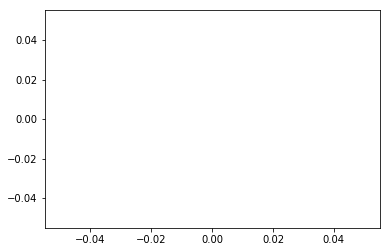

In [36]:
plt.scatter(pools,r1s)
plt.scatter(pools,r2s)
plt.show()